First Import All important libraries

In [ ]:
from IPython.display import clear_output 
# just to clear unwanted stuff from terminal

In [ ]:
!pip install -q tensorflow==2.3.1
clear_output()
# insalling tensorflow through which we will use inbluit libraries to execute our project

In [ ]:
!pip install -q tensorflow_quantum==0.4.0
# insatlling tensorflow_quantum  library for rapid prototyping of hybrid quantum-classical ML models. 
#Research in quantum algorithms and applications can leverage Google’s quantum computing frameworks, all from within TensorFlow.

In [ ]:
!pip install cirq==0.9.1
# just like qiskit , it is a libarary from which we can import quantum circuits and it functions just like qiskit

Now we have to import dataset

In [ ]:
# first we need to import installed tensorflow library in our notebook
import tensorflow as tf
# as we are working with multiple arrays so numpy is basic library to perform operations in easier way
import numpy as np
from sklearn.model_selection import train_test_split

# importing quantum libararies
import tensorflow_quantum as tfq
import cirq
import sympy

# Visualization tools
from cirq.contrib.svg import SVGCircuit  
import matplotlib.pyplot as plt

In [ ]:
# Since we are working on very famous MNIST datset and it can be imported from tensorflow library just by writing one line of code
from tensorflow.keras.datasets import fashion_mnist as dataset

In [ ]:
(x_train,y_train),(x_test,y_test) = dataset.load_data()

In [ ]:
x_train.shape

(60000, 28, 28)

In [ ]:
x_test.shape

(10000, 28, 28)

In [ ]:
y_train[0]

9

There is need of pre processing of data

In [ ]:
# filter the data
# we will work on only two classes
def filter(x,y):
  keep = (y==5)|(y==9)
  x,y=x[keep],y[keep]
  y=y==5
  return x,y

In [ ]:
x_train , y_train = filter(x_train , y_train)

In [ ]:
x_test , y_test = filter(x_test , y_test)

In [ ]:
x_train.shape

(12000, 28, 28)

In [ ]:
x_test.shape

(2000, 28, 28)

In [ ]:
y_train.shape

(12000,)

In [ ]:
y_train[0]

False

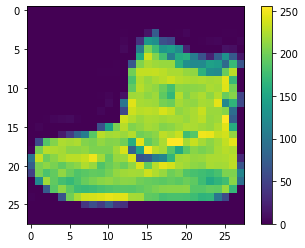

In [ ]:
#lets visualize first image
plt.imshow(x_train[0])
plt.colorbar()
plt.show()

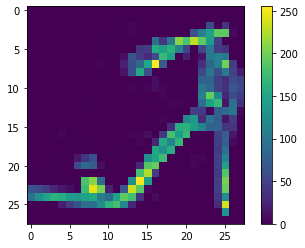

In [ ]:
plt.imshow(x_train[1])
plt.colorbar()
plt.show()

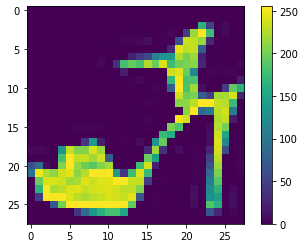

In [ ]:
plt.imshow(x_train[2])
plt.colorbar()
plt.show()

In [ ]:
x_train = x_train/255
y_train = y_train/255

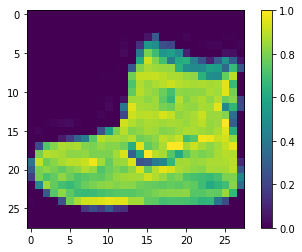

In [ ]:
plt.imshow(x_train[0])
plt.colorbar()
plt.show()

In [ ]:
x_train = x_train.reshape(x_train.shape[0],*(28,28,1))
x_test = x_test.reshape(x_test.shape[0],*(28,28,1))

In [ ]:
x_train = tf.image.resize(x_train , (2,2)).numpy()
x_test = tf.image.resize(x_test , (2,2)).numpy()

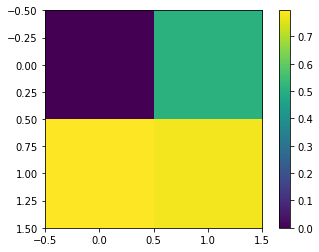

In [ ]:
plt.imshow(x_train[0,:,:,0])
plt.colorbar()
plt.show()

In [ ]:
x_train , x_valid , y_train , y_valid = train_test_split(x_train, y_train,test_size = 0.15 , random_state = 0)

Data encoding

In [ ]:
x_train = x_train.reshape(x_train.shape[0],*(1,4,1))
x_valid = x_valid.reshape(x_valid.shape[0],*(1,4,1))
x_test = x_test.reshape(x_test.shape[0],*(1,4,1))

In [ ]:
def binary_encode(x,threshold = 0.5):
  encode_images = list()
  for image in x:
    encode_image = [1 if j>threshold else 0 for j in image[0]]
    encode_images.append(encode_image)
  return np.array(encode_images)

In [ ]:
x_train = binary_encode(x_train)

In [ ]:
print(x_train[0])

[0 0 1 1]


In [ ]:
def create_circuit_from_image(encoded_image):
  qubits = cirq.GridQubit.rect(2,2)
  circuit = cirq.Circuit()
  for i,pixel in enumerate(encoded_image):
    if pixel:
      circuit.append(cirq.X(qubits[i]))
  return circuit

In [ ]:
x_train = [create_circuit_from_image(encoded_image) for encoded_image in x_train]

In [ ]:
print(x_train[0])

(1, 0): ───X───

(1, 1): ───X───


In [ ]:
x_train_tfq = tfq.convert_to_tensor(x_train)

In [ ]:
x_valid = binary_encode(x_valid)
x_test = binary_encode(x_test)

In [ ]:
x_valid = [create_circuit_from_image(encoded_image) for encoded_image in x_valid]

In [ ]:
x_test = [create_circuit_from_image(encoded_image) for encoded_image in x_test]

In [ ]:
x_valid_tfq = tfq.convert_to_tensor(x_valid)
x_test_tfq = tfq.convert_to_tensor(x_test)

In [ ]:
class QNN():
    def __init__(self, data_qubits, readout):
      self.data_qubits = data_qubits
      self.readout = readout

    def add_singleQubit_gate(self,circuit, gate, qubit_index):
      for index in qubit_index:
        circuit.append(gate(self.data_qubits[index]))

    def add_twoQubit_gate(self,circuit, gate, qubit_index):
      if len(qubit_index)!=2:
        raise Exception("The length of the list of indices passed for two qubit \
        gate operations must be equal to two")
      circuit.append(gate(self.data_qubits[qubit_index[0]], self.data_qubits[qubit_index[1]]))

    def add_layer(self, circuit, gate, symbol_gate):
      for i, qubit in enumerate(self.data_qubits):
        symbol = sympy.Symbol(symbol_gate+ '-' + str(i))
        circuit.append(gate(qubit, self.readout)**symbol)

In [ ]:
def create_qnn():
    data_qubits = cirq.GridQubit.rect(2,2)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()

    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))

    qnn = QNN(
        data_qubits = data_qubits,
        readout=readout)
    # Add the ising coupling XX gate
    qnn.add_layer(circuit, cirq.XX, "xx")
    qnn.add_layer(circuit, cirq.ZZ, "zz")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [ ]:
qmodel, model_readout = create_qnn()

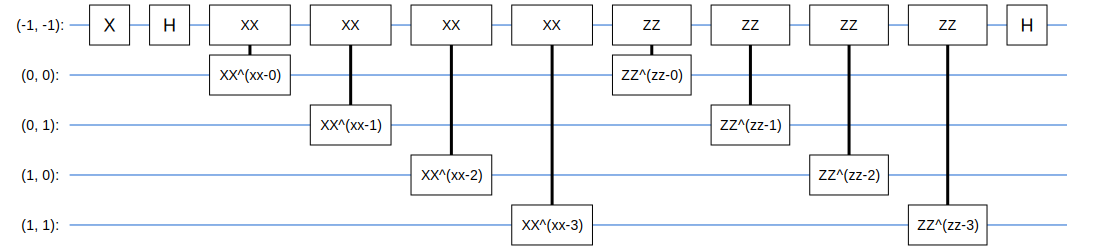

In [ ]:
SVGCircuit(qmodel)

In [ ]:
model = tf.keras.Sequential([
                             
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    tfq.layers.PQC(qmodel, model_readout),
])

In [ ]:
y_train_h = np.array([1 if i==1 else -1 for i in y_train ])
y_valid_h = np.array([1 if i==1 else -1 for i in y_valid ])
y_test_h = np.array([1 if i==1 else -1 for i in y_test ])

In [ ]:
print(y_train_h[0])

-1


In [ ]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [ ]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[hinge_accuracy])

In [ ]:
qnn_history = model.fit(
      x_train_tfq, y_train_h,
      batch_size=64,
      epochs=10,
      verbose=1,
      validation_data=(x_valid_tfq, y_valid_h))

Epoch 1/10
160/160 [==============================] - 8s 49ms/step - loss: 0.9101 - hinge_accuracy: 0.5896 - val_loss: 0.7504 - val_hinge_accuracy: 0.7069
Epoch 2/10
160/160 [==============================] - 7s 46ms/step - loss: 0.6118 - hinge_accuracy: 0.6872 - val_loss: 0.3690 - val_hinge_accuracy: 0.7069
Epoch 3/10
160/160 [==============================] - 8s 49ms/step - loss: 0.1827 - hinge_accuracy: 0.9676 - val_loss: 0.0443 - val_hinge_accuracy: 1.0000
Epoch 4/10
160/160 [==============================] - 8s 50ms/step - loss: 0.0157 - hinge_accuracy: 1.0000 - val_loss: 0.0022 - val_hinge_accuracy: 1.0000
Epoch 5/10
160/160 [==============================] - 8s 50ms/step - loss: 6.4428e-04 - hinge_accuracy: 1.0000 - val_loss: 5.5086e-05 - val_hinge_accuracy: 1.0000
Epoch 6/10
160/160 [==============================] - 8s 49ms/step - loss: 1.4144e-05 - hinge_accuracy: 1.0000 - val_loss: 8.1542e-07 - val_hinge_accuracy: 1.0000
Epoch 7/10
160/160 [==============================] - 

In [ ]:
model.evaluate(x_test_tfq, y_test_h)

63/63 [==============================] - 1s 16ms/step - loss: 1.0000 - hinge_accuracy: 0.5000


[1.0, 0.5]

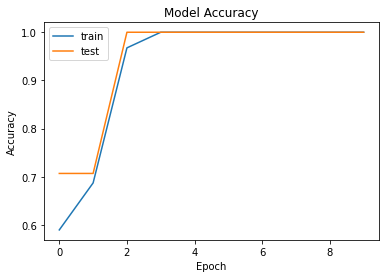

In [ ]:
plt.plot(qnn_history.history['hinge_accuracy'])
plt.plot(qnn_history.history['val_hinge_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train','test'],loc="best")
plt.show()

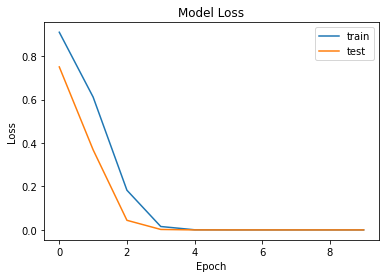

In [ ]:
plt.plot(qnn_history.history['loss'])
plt.plot(qnn_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','test'],loc="best")
plt.show()